In [12]:
import os
import random
from cryptography.hazmat.primitives.asymmetric import rsa, ec
from cryptography.hazmat.primitives.asymmetric.padding import OAEP, MGF1
from cryptography.hazmat.primitives.hashes import SHA256
from cryptography.hazmat.backends import default_backend
from prettytable import PrettyTable
import csv

# Simulate ElGamal-like encryption
class ElGamalSimulator:
    def __init__(self, key_size):
        self.key_size = key_size
        self.p = random.getrandbits(key_size)
        self.g = random.randint(2, self.p - 1)
        self.private_key = random.randint(1, self.p - 1)
        self.public_key = pow(self.g, self.private_key, self.p)

    def encrypt(self, data):
        k = random.randint(1, self.p - 1)
        c1 = pow(self.g, k, self.p)
        c2 = (int.from_bytes(data, 'big') * pow(self.public_key, k, self.p)) % self.p
        return c1, c2

# Generate RSA key pair
def generate_rsa_keypair(key_size):
    private_key = rsa.generate_private_key(
        public_exponent=65537, key_size=key_size, backend=default_backend()
    )
    return private_key

# Generate ECC key pair
def generate_ecc_keypair():
    private_key = ec.generate_private_key(ec.SECP256R1(), backend=default_backend())
    return private_key

# Chunk data for RSA encryption
def chunk_data(data, max_size):
    return [data[i:i + max_size] for i in range(0, len(data), max_size)]

# Measure ciphertext size
def measure_ciphertext_size(algorithm, private_key, public_key, data, max_chunk_size):
    if isinstance(algorithm, ElGamalSimulator):
        ciphertext = algorithm.encrypt(data)
        return len(str(ciphertext).encode('utf-8'))  # Simulate size in bytes
    elif isinstance(algorithm, rsa.RSAPrivateKey):
        chunks = chunk_data(data, max_chunk_size)
        ciphertext_size = 0
        for chunk in chunks:
            ciphertext = public_key.encrypt(
                chunk,
                OAEP(
                    mgf=MGF1(algorithm=SHA256()),
                    algorithm=SHA256(),
                    label=None
                )
            )
            ciphertext_size += len(ciphertext)
        return ciphertext_size
    elif isinstance(algorithm, ec.EllipticCurvePrivateKey):
        ciphertext = (public_key.public_numbers(), data)  # Simulate ECC ciphertext
        return len(str(ciphertext).encode('utf-8'))

# Main function
def main():
    # Define parameters
    data_sizes_kb = [2, 4, 8, 16, 32, 64, 128, 256]  # Test plaintext sizes in KB
    rsa_key_size = 2048
    elgamal_key_size = 2048

    # Generate keys
    rsa_private_key = generate_rsa_keypair(rsa_key_size)
    rsa_public_key = rsa_private_key.public_key()
    ecc_private_key = generate_ecc_keypair()
    ecc_public_key = ecc_private_key.public_key()
    elgamal_simulator = ElGamalSimulator(elgamal_key_size)

    # Determine maximum chunk size for RSA
    rsa_max_chunk_size = rsa_key_size // 8 - 2 * SHA256().digest_size - 2  # Based on OAEP padding

    # Algorithms to test
    algorithms_to_test = {
        "RSA": {"private_key": rsa_private_key, "public_key": rsa_public_key, "max_chunk_size": rsa_max_chunk_size},
        "ECC": {"private_key": ecc_private_key, "public_key": ecc_public_key, "max_chunk_size": len(data_sizes_kb) * 1024},
        "ElGamal": {"private_key": None, "public_key": None, "algorithm": elgamal_simulator, "max_chunk_size": elgamal_key_size},
    }

    # Prepare PrettyTable
    table = PrettyTable()
    table.field_names = ["Algorithm", "Data Size (KB)", "Ciphertext Size (Bytes)"]

    # CSV file for results
    csv_file = "ciphertext_sizes.csv"
    with open(csv_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Algorithm", "Data Size (KB)", "Ciphertext Size (Bytes)"])

        # Perform tests
        for algo_name, params in algorithms_to_test.items():
            private_key = params.get("private_key")
            public_key = params.get("public_key")
            algorithm = params.get("algorithm", private_key)
            max_chunk_size = params.get("max_chunk_size")

            for size_kb in data_sizes_kb:
                data = os.urandom(size_kb * 1024)  # Generate random plaintext
                ciphertext_size = measure_ciphertext_size(algorithm, private_key, public_key, data, max_chunk_size)

                # Add results to table and CSV
                table.add_row([algo_name, size_kb, ciphertext_size])
                writer.writerow([algo_name, size_kb, ciphertext_size])

    print(table)
    print(f"Results written to {csv_file}")

if __name__ == "__main__":
    main()


+-----------+----------------+-------------------------+
| Algorithm | Data Size (KB) | Ciphertext Size (Bytes) |
+-----------+----------------+-------------------------+
|    RSA    |       2        |           2816          |
|    RSA    |       4        |           5632          |
|    RSA    |       8        |          11264          |
|    RSA    |       16       |          22272          |
|    RSA    |       32       |          44288          |
|    RSA    |       64       |          88320          |
|    RSA    |      128       |          176640         |
|    RSA    |      256       |          353280         |
|    ECC    |       2        |           5983          |
|    ECC    |       4        |          12061          |
|    ECC    |       8        |          23833          |
|    ECC    |       16       |          47204          |
|    ECC    |       32       |          94155          |
|    ECC    |       64       |          188419         |
|    ECC    |      128       | 

In [24]:
import os
import random
import csv
from prettytable import PrettyTable
from cryptography.hazmat.primitives.asymmetric import rsa, ec
from cryptography.hazmat.primitives.asymmetric.padding import OAEP, MGF1
from cryptography.hazmat.primitives.hashes import SHA256
from cryptography.hazmat.backends import default_backend


# Generate plaintext data
def generate_plaintext(size_kb):
    return os.urandom(size_kb * 1024)  # Generate random data


# Measure ciphertext size for RSA
def measure_ciphertext_size_rsa(public_key, data):
    max_chunk_size = (2048 // 8) - 2 * SHA256().digest_size - 2  # OAEP padding size
    chunks = [data[i:i + max_chunk_size] for i in range(0, len(data), max_chunk_size)]
    ciphertext_size = 0
    for chunk in chunks:
        ciphertext = public_key.encrypt(
            chunk,
            OAEP(
                mgf=MGF1(algorithm=SHA256()),
                algorithm=SHA256(),
                label=None
            )
        )
        ciphertext_size += len(ciphertext)
    return ciphertext_size


# Measure ciphertext size for ECC
def measure_ciphertext_size_ecc(public_key, data):
    ciphertext = (public_key.public_numbers(), data)  # Include public key and data
    return len(str(ciphertext).encode('utf-8'))


# Simulate ElGamal encryption
class ElGamalSimulator:
    def __init__(self, key_size):
        self.key_size = key_size
        self.p = random.getrandbits(key_size)
        self.g = random.randint(2, self.p - 1)
        self.private_key = random.randint(1, self.p - 1)
        self.public_key = pow(self.g, self.private_key, self.p)

    def encrypt(self, data):
        k = random.randint(1, self.p - 1)
        c1 = pow(self.g, k, self.p)
        c2 = (int.from_bytes(data, 'big') * pow(self.public_key, k, self.p)) % self.p
        return c1, c2

    def measure_ciphertext_size(self, data):
        ciphertext = self.encrypt(data)
        return len(str(ciphertext).encode('utf-8'))


# Main function to test algorithms
def main():
    data_sizes_kb = [2, 4, 8, 16, 32, 64, 128, 256]  # Sizes in KB
    rsa_key_size = 2048
    elgamal_key_size = 2048

    # Generate RSA and ECC key pairs
    rsa_private_key = rsa.generate_private_key(
        public_exponent=65537,
        key_size=rsa_key_size,
        backend=default_backend()
    )
    rsa_public_key = rsa_private_key.public_key()

    ecc_private_key = ec.generate_private_key(ec.SECP256R1(), backend=default_backend())
    ecc_public_key = ecc_private_key.public_key()

    elgamal_simulator = ElGamalSimulator(elgamal_key_size)

    # Prepare PrettyTable
    table = PrettyTable()
    table.field_names = ["Algorithm", "Data Size (KB)", "Ciphertext Size (Bytes)"]

    # CSV file for results
    csv_file = "ciphertext_size_comparison.csv"
    with open(csv_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Algorithm", "Data Size (KB)", "Ciphertext Size (Bytes)"])

        # Test RSA
        for size_kb in data_sizes_kb:
            data = generate_plaintext(size_kb)
            ciphertext_size = measure_ciphertext_size_rsa(rsa_public_key, data)
            table.add_row(["RSA", size_kb, ciphertext_size])
            writer.writerow(["RSA", size_kb, ciphertext_size])

        # Test ECC
        for size_kb in data_sizes_kb:
            data = generate_plaintext(size_kb)
            ciphertext_size = measure_ciphertext_size_ecc(ecc_public_key, data)
            table.add_row(["ECC", size_kb, ciphertext_size])
            writer.writerow(["ECC", size_kb, ciphertext_size])

        # Test ElGamal
        for size_kb in data_sizes_kb:
            data = generate_plaintext(size_kb)
            ciphertext_size = elgamal_simulator.measure_ciphertext_size(data)
            table.add_row(["ElGamal", size_kb, ciphertext_size])
            writer.writerow(["ElGamal", size_kb, ciphertext_size])

    print(table)
    print(f"Results written to {csv_file}")


if __name__ == "__main__":
    main()


+-----------+----------------+-------------------------+
| Algorithm | Data Size (KB) | Ciphertext Size (Bytes) |
+-----------+----------------+-------------------------+
|    RSA    |       2        |           2816          |
|    RSA    |       4        |           5632          |
|    RSA    |       8        |          11264          |
|    RSA    |       16       |          22272          |
|    RSA    |       32       |          44288          |
|    RSA    |       64       |          88320          |
|    RSA    |      128       |          176640         |
|    RSA    |      256       |          353280         |
|    ECC    |       2        |           6124          |
|    ECC    |       4        |          12028          |
|    ECC    |       8        |          23858          |
|    ECC    |       16       |          47052          |
|    ECC    |       32       |          94272          |
|    ECC    |       64       |          188172         |
|    ECC    |      128       | 

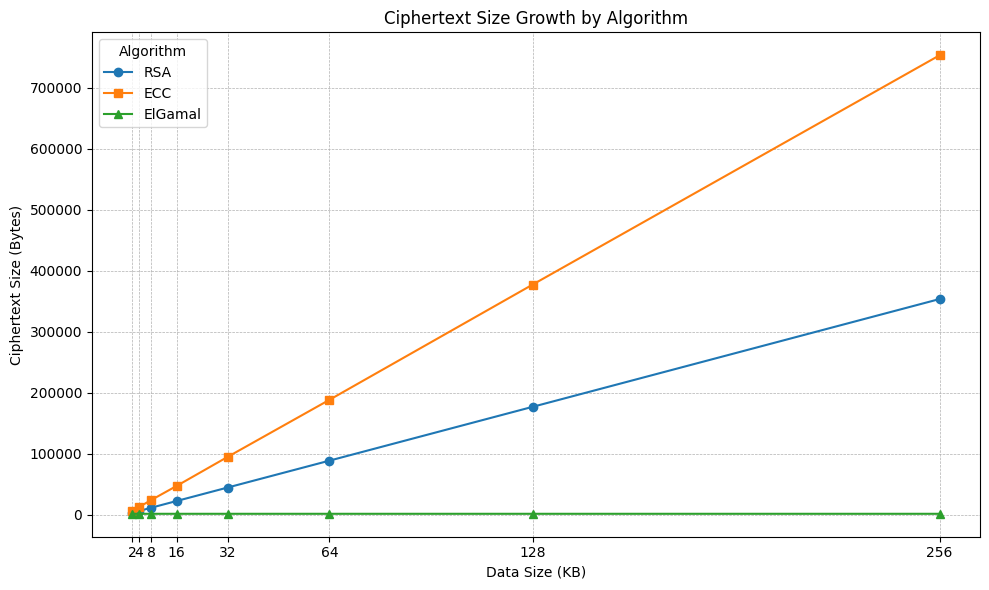

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from CSV file
file_path = "ciphertext_size_comparison.csv"
data = pd.read_csv(file_path)

# Convert Data Size (KB) and Ciphertext Size (Bytes) columns to lists
data_sizes = data['Data Size (KB)'].unique()
rsa_sizes = data[data['Algorithm'] == 'RSA']['Ciphertext Size (Bytes)']
ecc_sizes = data[data['Algorithm'] == 'ECC']['Ciphertext Size (Bytes)']
elgamal_sizes = data[data['Algorithm'] == 'ElGamal']['Ciphertext Size (Bytes)']

# Plot Ciphertext Sizes for Each Algorithm
plt.figure(figsize=(10, 6))
plt.plot(data_sizes, rsa_sizes, marker='o', label="RSA")
plt.plot(data_sizes, ecc_sizes, marker='s', label="ECC")
plt.plot(data_sizes, elgamal_sizes, marker='^', label="ElGamal")

# Customize the plot
plt.title("Ciphertext Size Growth by Algorithm")
plt.xlabel("Data Size (KB)")
plt.ylabel("Ciphertext Size (Bytes)")
plt.legend(title="Algorithm")
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.xticks(data_sizes)
plt.tight_layout()

# Show the plot
plt.show()
